In [5]:
#load the dataset
import pandas as pd

# Load the Excel file
df = pd.read_excel('/online_retail_II.xlsx')

# Show the first 5 rows
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
#clean the data
# Remove missing values
df.dropna(inplace=True)

# Remove canceled orders (InvoiceNo starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Filter only positive quantity and unit price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Check cleaned data
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
# Remove rows with missing CustomerID or InvoiceNo starting with 'C' (cancelled)
df.dropna(subset=['Customer ID'], inplace=True)
df = df[~df['Invoice'].astype(str).str.startswith('C')]
df['Customer ID'] = df['Customer ID'].astype(int)
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]


In [10]:
#create rmf features
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,   # Recency
    'Invoice': 'nunique',                                      # Frequency
    'Price': lambda x: (x * df.loc[x.index, 'Quantity']).sum() # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
Customer ID,,,
12346,165,11,372.86
12347,3,2,1323.32
12348,74,1,222.16
12349,43,3,2671.14
12351,11,1,300.93


In [11]:
#normalize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)


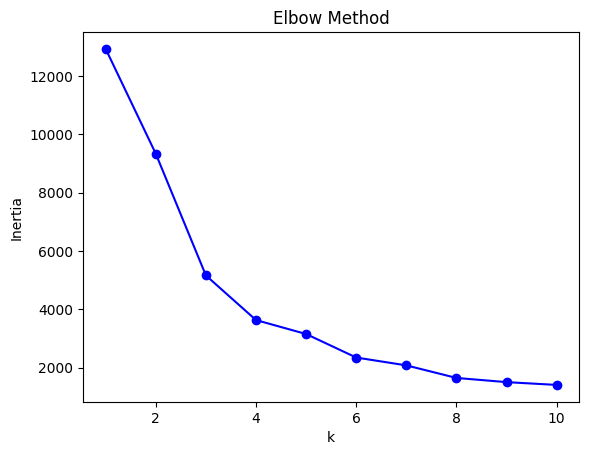

In [12]:
#apply k-means clusturing
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find optimal k
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


In [13]:
#fit final model
k = 4  # or whatever you choose
kmeans = KMeans(n_clusters=k, random_state=1)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)
rfm.head()


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346,165,11,372.86,2
12347,3,2,1323.32,0
12348,74,1,222.16,0
12349,43,3,2671.14,0
12351,11,1,300.93,0


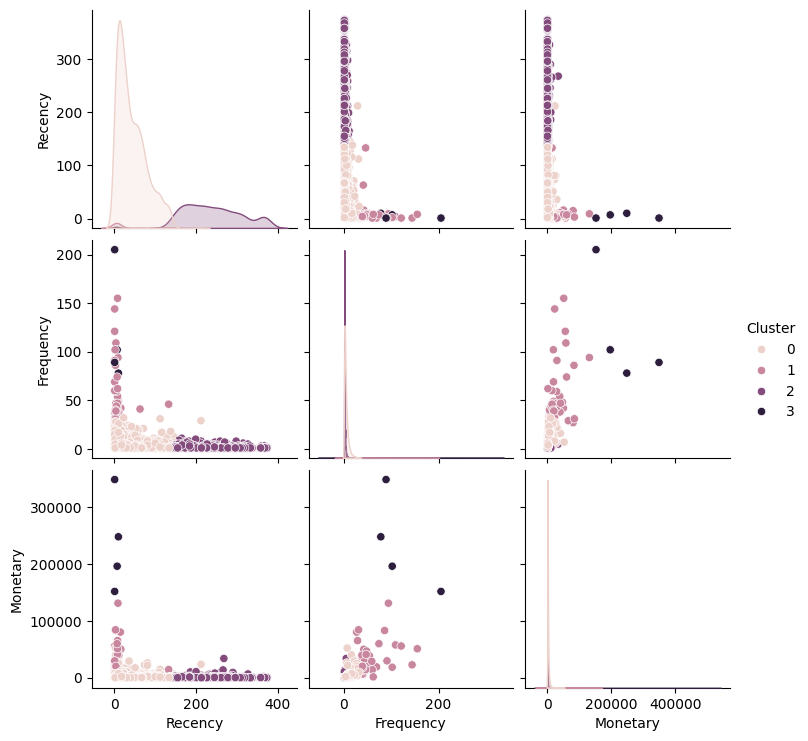

In [14]:
#visualize clusters
import seaborn as sns

sns.pairplot(rfm, hue='Cluster', diag_kind='kde')
plt.show()
